In [11]:
import os
import glob
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class UCSDVideoDataset(Dataset):
    def __init__(self, root_dir, seq_len=10, transform=None):
        self.seq_len = seq_len
        self.transform = transform
        self.sequences = []

        video_folders = sorted(glob.glob(os.path.join(root_dir, "*")))
        for folder in video_folders:
            frame_paths = sorted(glob.glob(os.path.join(folder, '*.tif')))
            # Create sequences of frames
            for i in range(len(frame_paths) - seq_len):
                self.sequences.append(frame_paths[i:i + seq_len])

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        frames = []
        for path in self.sequences[idx]:
            img = Image.open(path).convert('L')  # grayscale
            if self.transform:
                img = self.transform(img)
            frames.append(img)

        return torch.stack(frames)  # shape: [seq_len, 1, H, W]


In [12]:
import torch.nn as nn

class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size):
        super().__init__()
        padding = kernel_size // 2
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels

        self.conv = nn.Conv2d(input_channels + hidden_channels,
                              4 * hidden_channels,
                              kernel_size,
                              padding=padding)

    def forward(self, x, h, c):
        combined = torch.cat([x, h], dim=1)
        conv_output = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.chunk(conv_output, 4, dim=1)

        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

class ConvLSTMAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),  # (B, 1, 128, 128) → (B, 64, 128, 128)
            nn.ReLU(),
            nn.MaxPool2d(2),                # → (B, 64, 64, 64)
        )

        self.convlstm = ConvLSTMCell(64, 64, 3)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 2, stride=2),  # (B, 64, 64, 64) → (B, 64, 128, 128)
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, padding=1),           # → (B, 1, 128, 128)
            nn.Sigmoid()
        )

    def forward(self, input_seq):  # input_seq: (B, T, 1, H, W)
        b, t, c, h, w = input_seq.size()
        h_t, c_t = (torch.zeros(b, 64, h // 2, w // 2, device=input_seq.device),
                    torch.zeros(b, 64, h // 2, w // 2, device=input_seq.device))
        outputs = []

        for time in range(t):
            x = self.encoder(input_seq[:, time])
            h_t, c_t = self.convlstm(x, h_t, c_t)
            out = self.decoder(h_t)
            outputs.append(out)

        return torch.stack(outputs, dim=1)  # (B, T, 1, H, W)


In [16]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm

# Parameters
SEQ_LEN = 10
BATCH_SIZE = 4
EPOCHS = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset & DataLoader
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_dataset = UCSDVideoDataset(
    root_dir="H:/Anomaly Detection in cctv/archive (1)/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train",
    seq_len=SEQ_LEN,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model
model = ConvLSTMAutoencoder().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

In [ ]:


# Training
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    pbar = tqdm(train_loader)
    for batch in pbar:
        batch = batch.to(DEVICE)  # (B, T, C, H, W)
        output = model(batch)
        loss = loss_fn(output, batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pbar.set_description(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")

    print(f"Epoch [{epoch+1}/{EPOCHS}], Avg Loss: {epoch_loss / len(train_loader):.4f}")


Epoch 1 | Loss: 0.0005: 100%|██████████| 1615/1615 [04:00<00:00,  6.70it/s]


Epoch [1/20], Avg Loss: 0.0033


Epoch 2 | Loss: 0.0002: 100%|██████████| 1615/1615 [03:36<00:00,  7.45it/s]


Epoch [2/20], Avg Loss: 0.0003


Epoch 3 | Loss: 0.0002: 100%|██████████| 1615/1615 [03:37<00:00,  7.43it/s]


Epoch [3/20], Avg Loss: 0.0002


Epoch 4 | Loss: 0.0002: 100%|██████████| 1615/1615 [03:37<00:00,  7.41it/s]


Epoch [4/20], Avg Loss: 0.0002


Epoch 5 | Loss: 0.0001: 100%|██████████| 1615/1615 [03:37<00:00,  7.42it/s]


Epoch [5/20], Avg Loss: 0.0001


Epoch 6 | Loss: 0.0001: 100%|██████████| 1615/1615 [03:35<00:00,  7.49it/s]


Epoch [6/20], Avg Loss: 0.0001


Epoch 7 | Loss: 0.0001: 100%|██████████| 1615/1615 [03:37<00:00,  7.42it/s]


Epoch [7/20], Avg Loss: 0.0001


Epoch 8 | Loss: 0.0001: 100%|██████████| 1615/1615 [03:38<00:00,  7.40it/s]


Epoch [8/20], Avg Loss: 0.0001


Epoch 9 | Loss: 0.0001: 100%|██████████| 1615/1615 [03:37<00:00,  7.42it/s]


Epoch [9/20], Avg Loss: 0.0001


Epoch 10 | Loss: 0.0001: 100%|██████████| 1615/1615 [03:37<00:00,  7.42it/s]


Epoch [10/20], Avg Loss: 0.0001


Epoch 11 | Loss: 0.0001: 100%|██████████| 1615/1615 [03:37<00:00,  7.43it/s]


Epoch [11/20], Avg Loss: 0.0001


Epoch 12 | Loss: 0.0001: 100%|██████████| 1615/1615 [03:37<00:00,  7.44it/s]


Epoch [12/20], Avg Loss: 0.0001


Epoch 13 | Loss: 0.0001: 100%|██████████| 1615/1615 [03:29<00:00,  7.72it/s]


Epoch [13/20], Avg Loss: 0.0001


Epoch 14 | Loss: 0.0001: 100%|██████████| 1615/1615 [03:27<00:00,  7.77it/s]


Epoch [14/20], Avg Loss: 0.0001


Epoch 15 | Loss: 0.0001: 100%|██████████| 1615/1615 [03:27<00:00,  7.77it/s]


Epoch [15/20], Avg Loss: 0.0001


Epoch 16 | Loss: 0.0001: 100%|██████████| 1615/1615 [03:28<00:00,  7.76it/s]


Epoch [16/20], Avg Loss: 0.0001


Epoch 17 | Loss: 0.0001: 100%|██████████| 1615/1615 [03:26<00:00,  7.80it/s]


Epoch [17/20], Avg Loss: 0.0001


Epoch 18 | Loss: 0.0001: 100%|██████████| 1615/1615 [03:26<00:00,  7.81it/s]


Epoch [18/20], Avg Loss: 0.0001


Epoch 19 | Loss: 0.0001: 100%|██████████| 1615/1615 [03:26<00:00,  7.82it/s]


Epoch [19/20], Avg Loss: 0.0001


Epoch 20 | Loss: 0.0000: 100%|██████████| 1615/1615 [03:26<00:00,  7.81it/s]

Epoch [20/20], Avg Loss: 0.0001


In [17]:
# Save model
torch.save(model.state_dict(), "conv_lstm_autoencoder_ucsd.pth")
print("Model saved as conv_lstm_autoencoder_ucsd.pth")


Model saved as conv_lstm_autoencoder_ucsd.pth


In [18]:
model.load_state_dict(torch.load("conv_lstm_autoencoder_ucsd.pth"))
model.eval()


ConvLSTMAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convlstm): ConvLSTMCell(
    (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Sigmoid()
  )
)

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def infer_and_score(model, test_folder, seq_len=10):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])

    frame_paths = sorted(glob.glob(os.path.join(test_folder, "*.tif")))
    mse_scores = []

    with torch.no_grad():
        for i in range(len(frame_paths) - seq_len):
            sequence = []
            for j in range(i, i + seq_len):
                img = Image.open(frame_paths[j]).convert('L')
                img = transform(img)
                sequence.append(img)

            input_seq = torch.stack(sequence).unsqueeze(0).to(DEVICE)  # (1, T, 1, H, W)
            recon_seq = model(input_seq)

            # Compute MSE on each frame
            mse = torch.mean((input_seq - recon_seq) ** 2, dim=[2, 3, 4])  # shape: (1, T)
            mse_scores.extend(mse.cpu().numpy()[0])

    return mse_scores


In [21]:
def plot_anomaly_scores(scores, threshold=None):
    plt.figure(figsize=(12, 4))
    plt.plot(scores, label="Reconstruction Error")
    if threshold:
        plt.axhline(threshold, color='red', linestyle='--', label="Threshold")
    plt.title("Anomaly Score per Frame")
    plt.xlabel("Frame Index")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid()
    plt.show()


In [5]:
def show_frame_and_reconstruction(model, frame_paths, idx, seq_len=10):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])
    sequence = []
    for j in range(idx, idx + seq_len):
        img = Image.open(frame_paths[j]).convert('L')
        img_tensor = transform(img)
        sequence.append(img_tensor)

    input_seq = torch.stack(sequence).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        recon_seq = model(input_seq)

    input_img = input_seq[0, -1].cpu().squeeze().numpy()
    recon_img = recon_seq[0, -1].detach().cpu().squeeze().numpy()

    error_map = np.abs(input_img - recon_img)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(input_img, cmap='gray')
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Reconstructed")
    plt.imshow(recon_img, cmap='gray')
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Error Heatmap")
    plt.imshow(error_map, cmap='hot')
    plt.axis("off")

    plt.show()


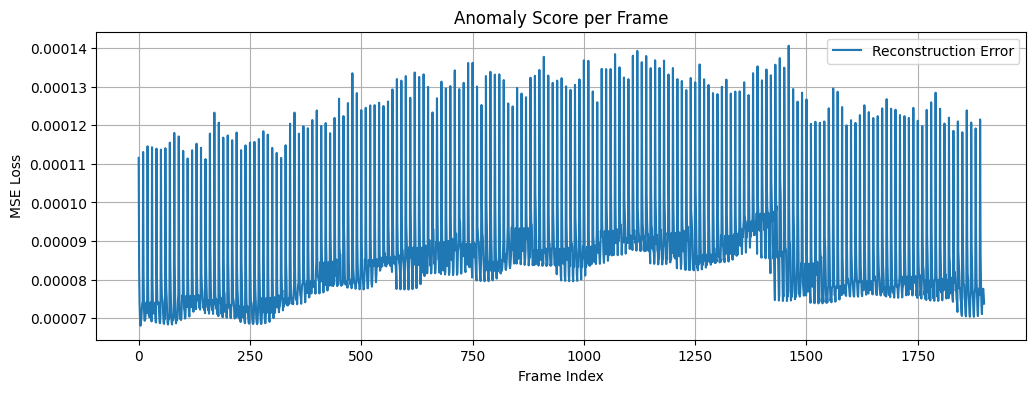

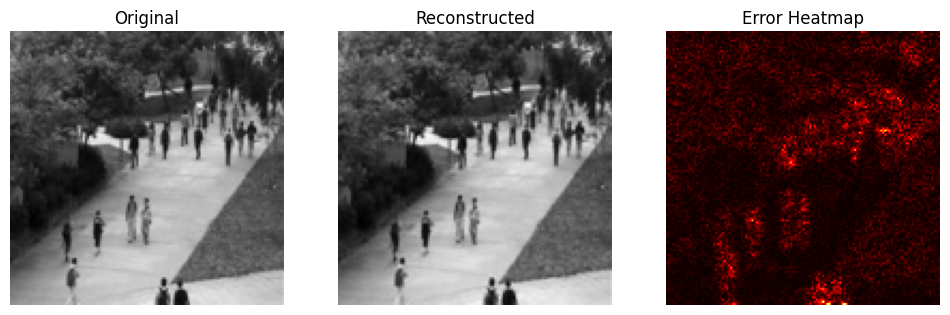

In [18]:
# Load model
model.load_state_dict(torch.load("conv_lstm_autoencoder_ucsd.pth"))
model.eval()

# Run inference on a test video folder
test_folder = "H:/Anomaly Detection in cctv/archive (1)/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test001"
scores = infer_and_score(model, test_folder)

# Plot anomaly scores
plot_anomaly_scores(scores)

# Show example frame + reconstruction
frame_paths = sorted(glob.glob(os.path.join(test_folder, "*.tif")))
show_frame_and_reconstruction(model, frame_paths, idx=50)


In [22]:
import cv2

def load_video_frames(video_path, resize=(128, 128)):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray, resize)
        gray = gray / 255.0  # normalize to [0, 1]
        frames.append(gray)

    cap.release()
    return np.array(frames)  # shape: (N, H, W)


In [26]:
def infer_on_video(model, frames_np, seq_len=10, device="cuda"):
    model.eval()
    scores = []

    with torch.no_grad():
        for i in range(len(frames_np) - seq_len):
            seq = frames_np[i:i + seq_len]  # shape: (T, H, W)

            # Normalize and convert to torch tensor
            seq_tensor = torch.tensor(seq, dtype=torch.float32) / 255.0  # ensure float32 + normalized
            seq_tensor = seq_tensor.unsqueeze(1)  # shape: (T, 1, H, W)
            input_seq = seq_tensor.unsqueeze(0).to(device)  # shape: (1, T, 1, H, W)

            # DEBUG: Check input shape
            print("input_seq shape:", input_seq.shape)

            recon_seq = model(input_seq)  # should output (1, T, 1, H, W)

            mse = torch.mean((input_seq - recon_seq) ** 2, dim=[2, 3, 4])  # shape: (1, T)
            scores.append(mse[0, -1].item())  # use last frame's reconstruction error

    return scores


In [85]:
def anomaly_timestamps(scores, fps=25, threshold=None):
    if threshold is None:
        threshold = np.percentile(scores, 60)  # Top 5%

    anomalies = []
    for i, score in enumerate(scores):
        if score > threshold:
            time_in_sec = round((i + 1) / fps, 2)  # +1 to align with output frame
            anomalies.append((i + 1, time_in_sec, score))

    return anomalies, threshold


input_seq shape: torch.Size([1, 10, 1, 128, 128])
input_seq shape: torch.Size([1, 10, 1, 128, 128])
input_seq shape: torch.Size([1, 10, 1, 128, 128])
input_seq shape: torch.Size([1, 10, 1, 128, 128])
input_seq shape: torch.Size([1, 10, 1, 128, 128])
input_seq shape: torch.Size([1, 10, 1, 128, 128])
input_seq shape: torch.Size([1, 10, 1, 128, 128])
input_seq shape: torch.Size([1, 10, 1, 128, 128])
input_seq shape: torch.Size([1, 10, 1, 128, 128])
input_seq shape: torch.Size([1, 10, 1, 128, 128])
input_seq shape: torch.Size([1, 10, 1, 128, 128])
input_seq shape: torch.Size([1, 10, 1, 128, 128])
input_seq shape: torch.Size([1, 10, 1, 128, 128])
input_seq shape: torch.Size([1, 10, 1, 128, 128])
input_seq shape: torch.Size([1, 10, 1, 128, 128])
input_seq shape: torch.Size([1, 10, 1, 128, 128])
input_seq shape: torch.Size([1, 10, 1, 128, 128])
input_seq shape: torch.Size([1, 10, 1, 128, 128])
input_seq shape: torch.Size([1, 10, 1, 128, 128])
input_seq shape: torch.Size([1, 10, 1, 128, 128])


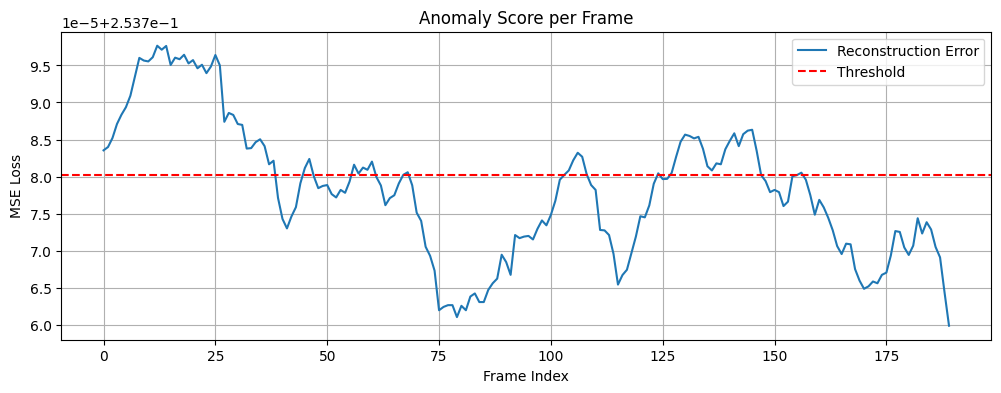

In [86]:
video_path ="test003.mp4"
fps = 25  # adjust if needed

frames = load_video_frames(video_path)
scores = infer_on_video(model, frames, seq_len=10, device=DEVICE)
anomalies, threshold = anomaly_timestamps(scores, fps=fps)

print(f"Anomalies (frame index, time [sec], score):")
for frame_idx, timestamp, score in anomalies:
    print(f"Frame {frame_idx}, Time: {timestamp}s, Score: {score:.4f}")

# Optional: plot scores
plot_anomaly_scores(scores, threshold)


In [87]:
import matplotlib.pyplot as plt

def plot_anomalous_frames(frames, anomalies, seq_len=20):
    """
    Plot frames identified as anomalous.
    
    Parameters:
        frames: full list of frames from video (np arrays)
        anomalies: list of frame indices flagged as anomalous
        seq_len: number of frames used in each sequence
    """
    for frame_idx, _, score in anomalies:
        actual_idx = frame_idx + seq_len  # offset due to sequence
        if actual_idx < len(frames):
            plt.figure(figsize=(4, 4))
            plt.imshow(frames[actual_idx], cmap="gray")
            plt.title(f"Anomaly at Frame {actual_idx} (score={score:.4f})")
            plt.axis("off")
            plt.show()


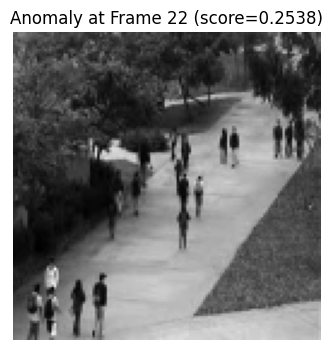

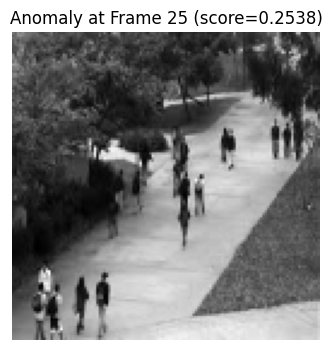

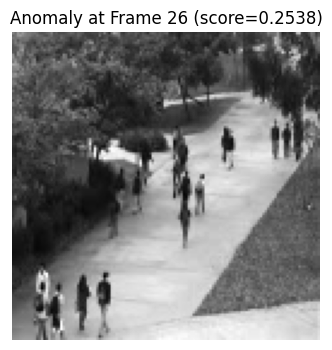

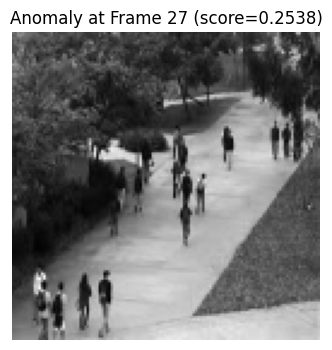

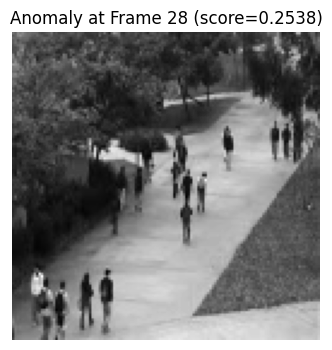

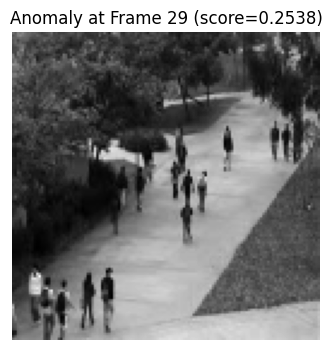

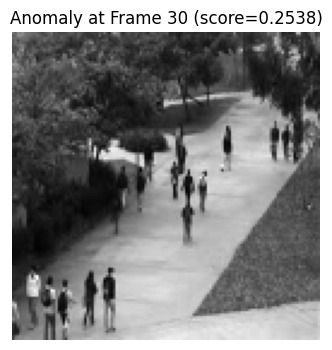

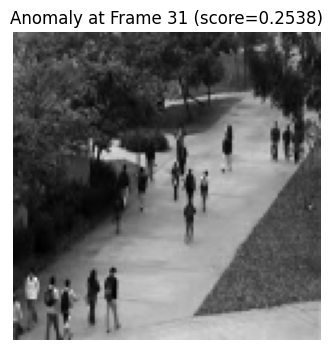

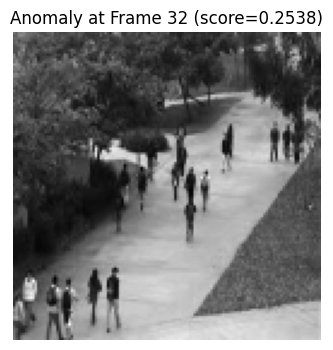

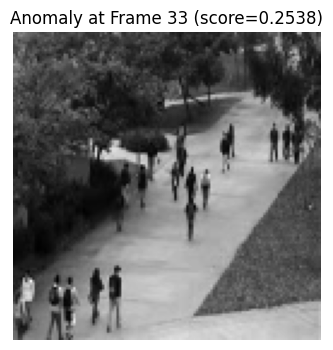

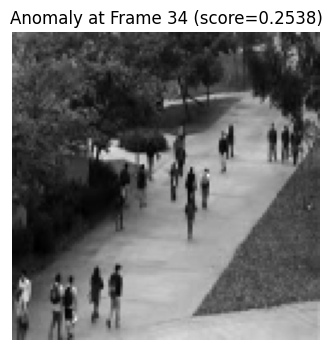

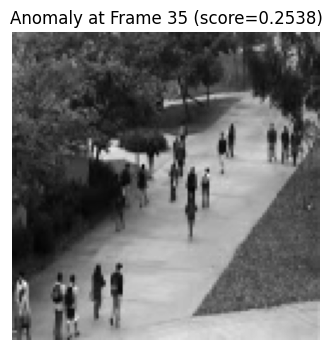

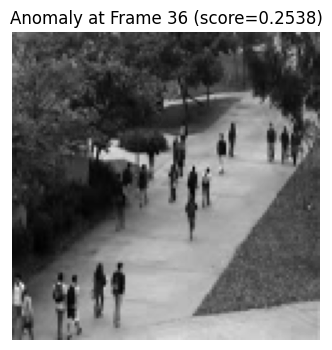

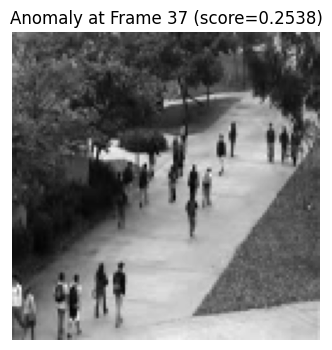

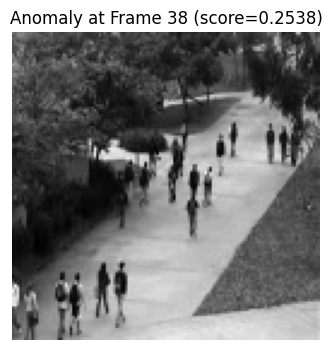

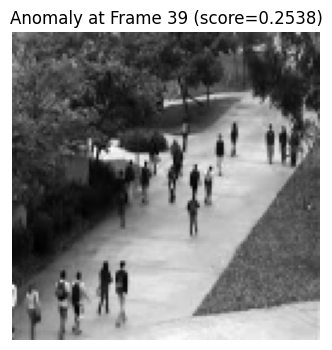

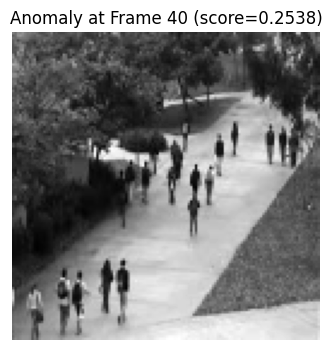

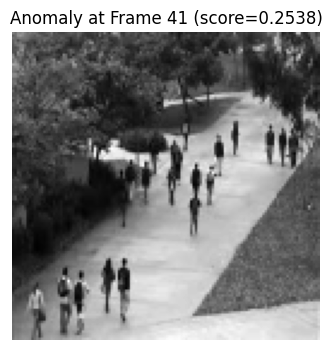

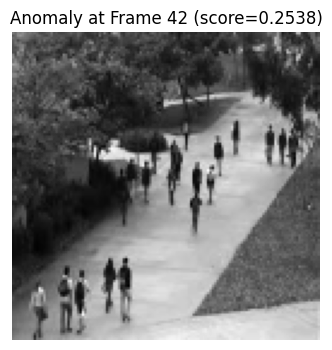

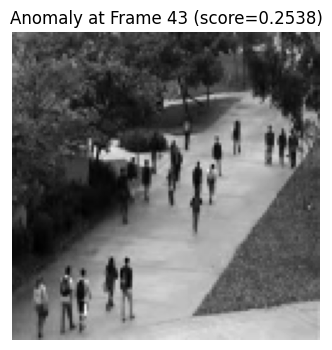

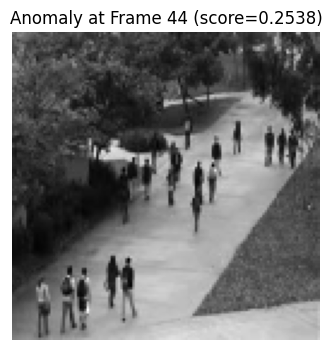

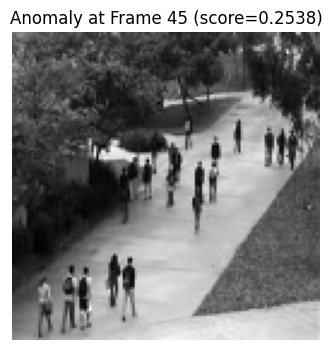

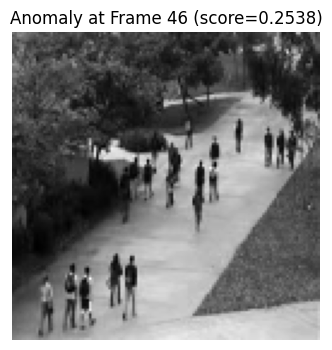

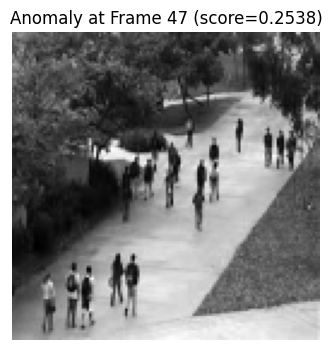

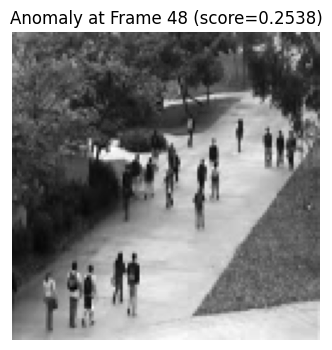

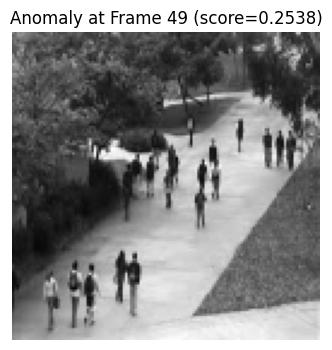

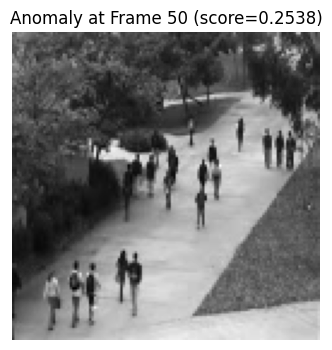

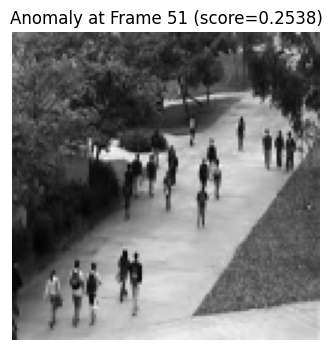

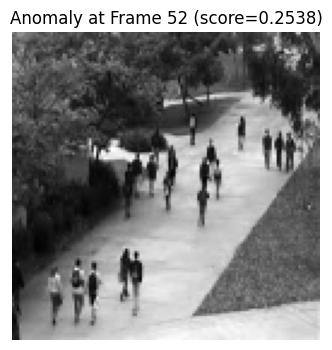

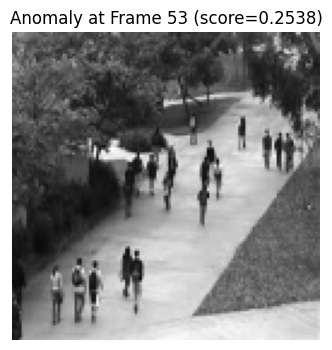

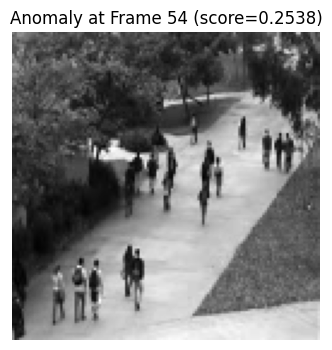

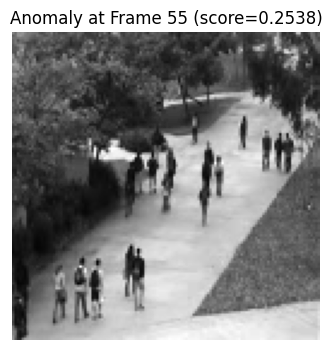

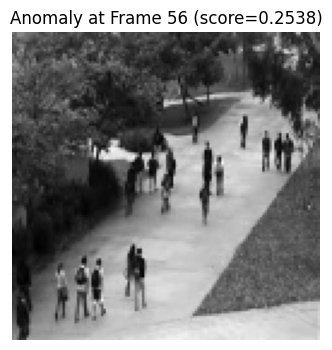

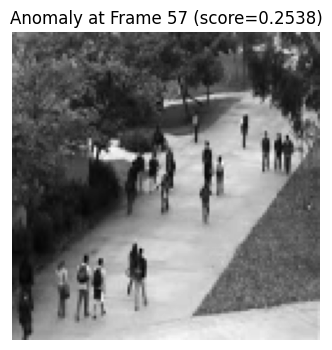

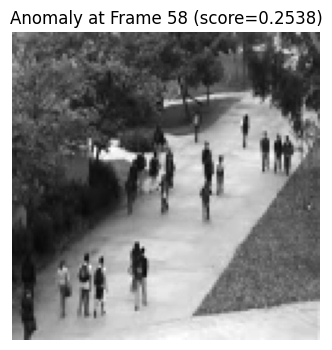

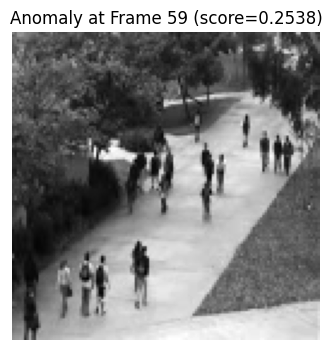

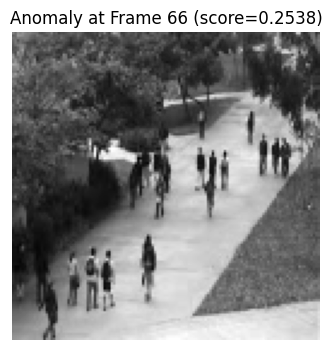

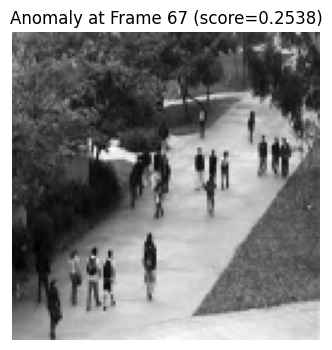

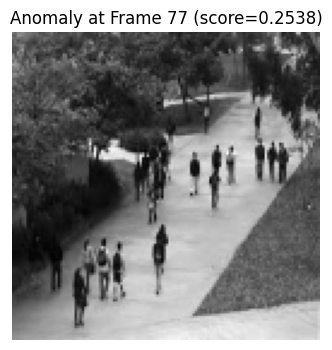

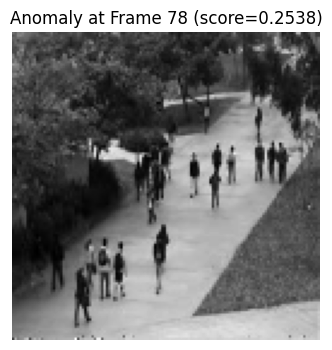

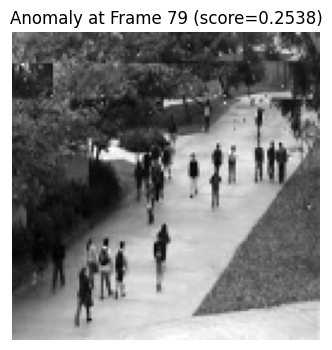

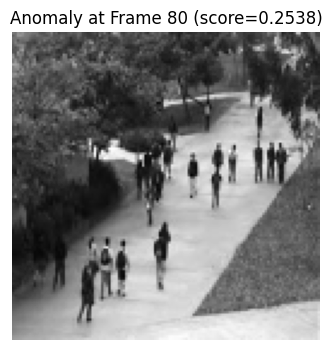

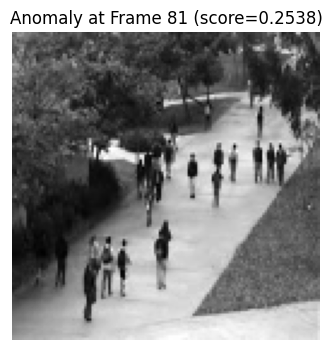

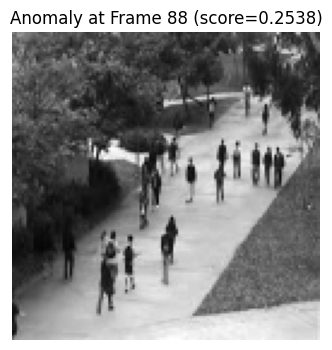

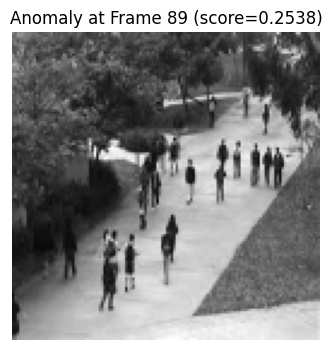

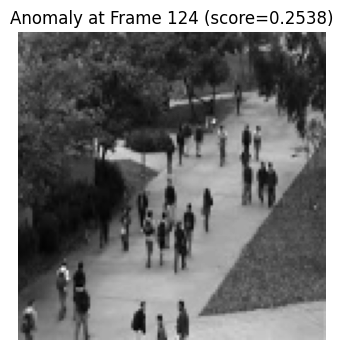

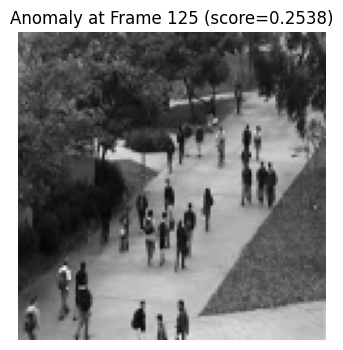

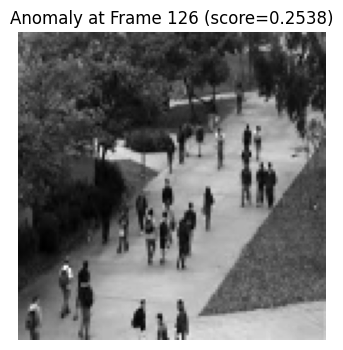

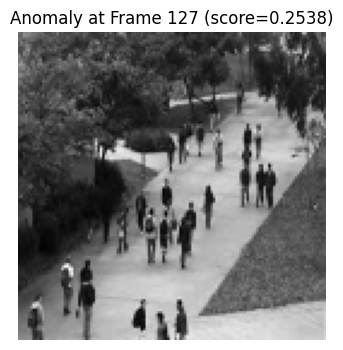

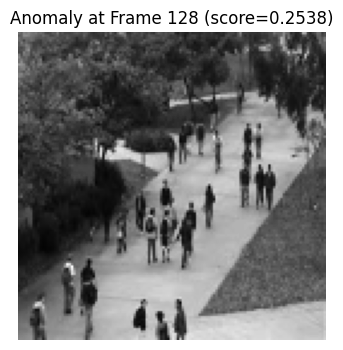

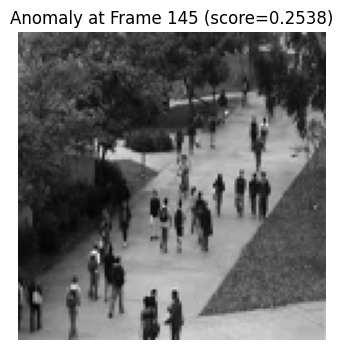

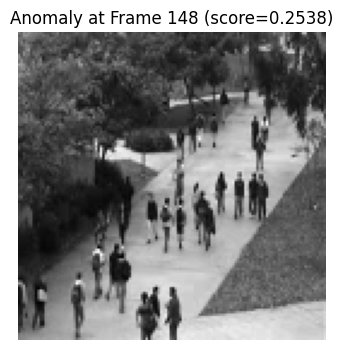

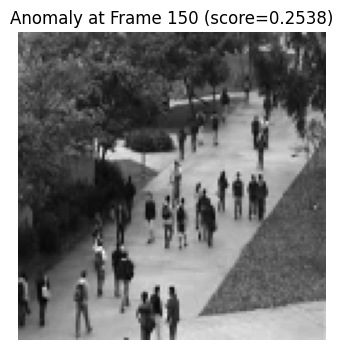

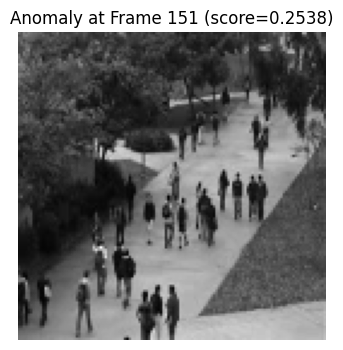

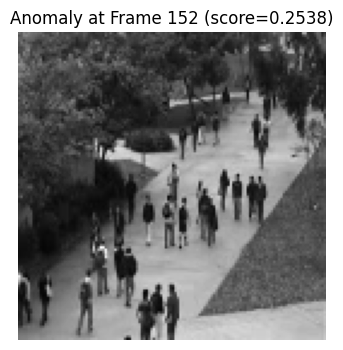

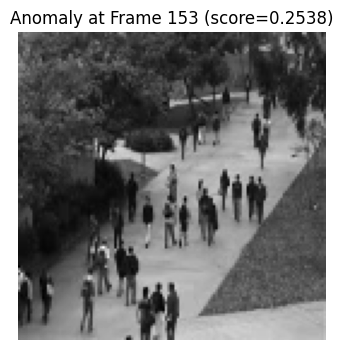

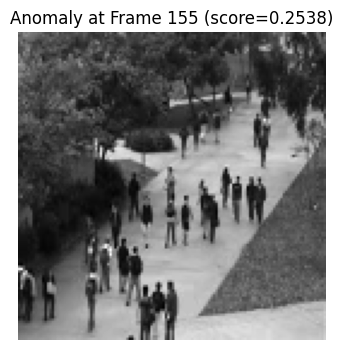

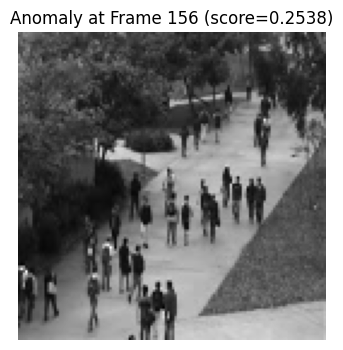

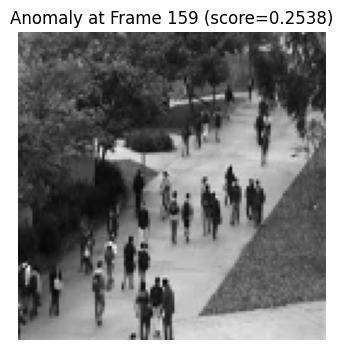

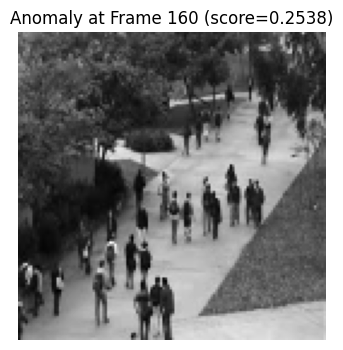

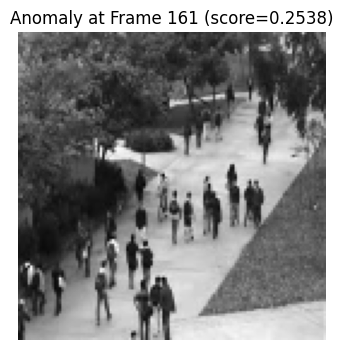

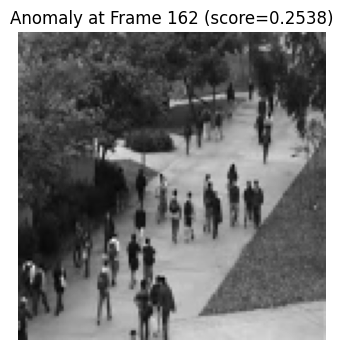

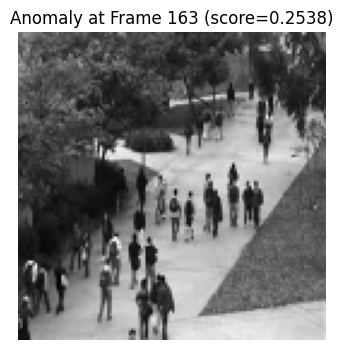

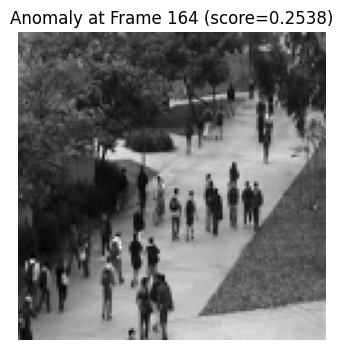

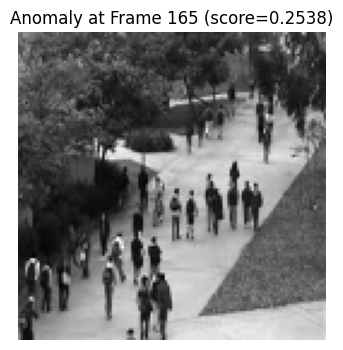

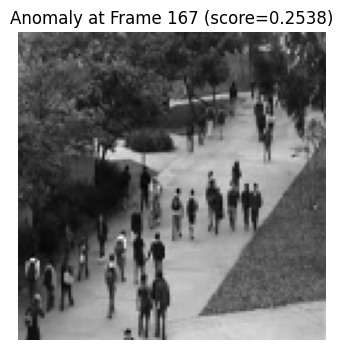

In [88]:
plot_anomalous_frames(frames, anomalies, seq_len=20)


In [89]:
import cv2
import numpy as np

def save_anomaly_video(frames, anomalies, output_video="anomaly_only1.mp4", fps=25, seq_len=20):
    """
    Save a video with only anomaly frames, with proper format handling.
    
    Parameters:
    - frames: list of grayscale frames as numpy arrays (any dtype)
    - anomalies: list of (index, time, score)
    - output_video: path to save video
    - fps: frames per second
    - seq_len: offset used during detection
    """
    if len(frames) == 0 or len(anomalies) == 0:
        print("❌ No frames or anomalies provided.")
        return

    # Preprocess: ensure first frame gives valid shape
    sample_frame = frames[0]
    if len(sample_frame.shape) == 3 and sample_frame.shape[0] == 1:
        sample_frame = sample_frame[0]
    sample_frame = np.clip(sample_frame * 255 if sample_frame.max() <= 1.0 else sample_frame, 0, 255).astype(np.uint8)

    height, width = sample_frame.shape
    out = cv2.VideoWriter(output_video, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    written = 0
    for i, (idx, _, score) in enumerate(anomalies):
        actual_idx = idx + seq_len
        if actual_idx >= len(frames):
            continue

        frame = frames[actual_idx]

        # Fix shape if needed (1, H, W) → (H, W)
        if len(frame.shape) == 3 and frame.shape[0] == 1:
            frame = frame[0]

        # Normalize if in float range
        if frame.dtype != np.uint8:
            frame = np.clip(frame * 255 if frame.max() <= 1.0 else frame, 0, 255).astype(np.uint8)

        # Convert grayscale → BGR
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)

        # Overlay anomaly score
        cv2.putText(frame_bgr, f"Anomaly Score: {score:.4f}", (10, 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

        out.write(frame_bgr)
        written += 1

    out.release()
    if written:
        print(f"✅ Anomaly video saved with {written} frames → {output_video}")
    else:
        print("⚠️ No valid frames written — check data type or shape.")


In [90]:
save_anomaly_video(frames, anomalies, output_video="anomaly_only1.mp4", fps=25)

✅ Anomaly video saved with 76 frames → anomaly_only1.mp4


Evaluating the model

In [91]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(pred_scores, gt_labels, threshold=0.02):
    """
    Evaluate model accuracy using predicted scores and ground truth labels.
    
    Parameters:
    - pred_scores: list of float anomaly scores (len=N)
    - gt_labels: list of int ground truth labels (0=normal, 1=anomaly) (len=N)
    - threshold: threshold on score to convert to binary prediction

    Returns: dict of metrics
    """
    if len(pred_scores) != len(gt_labels):
        raise ValueError("Length mismatch: predicted scores and ground truth labels")

    pred_labels = [1 if s > threshold else 0 for s in pred_scores]

    acc = accuracy_score(gt_labels, pred_labels)
    prec = precision_score(gt_labels, pred_labels, zero_division=0)
    rec = recall_score(gt_labels, pred_labels, zero_division=0)
    f1 = f1_score(gt_labels, pred_labels, zero_division=0)

    return {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1
    }


In [101]:
import glob
import numpy as np
import cv2
import os

def load_gt_labels(gt_folder):
    """
    Loads ground truth labels from a `_gt` folder (one per frame).
    Returns binary list: 1 = anomaly, 0 = normal
    """
    mask_paths = sorted(glob.glob(os.path.join(gt_folder, "*.tif")))
    labels = []

    for path in mask_paths:
        mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            continue
        # If any pixel in mask is non-zero, it's an anomaly frame
        is_anomaly = 1 if np.any(mask > 0) else 0
        labels.append(is_anomaly)

    return labels


In [103]:
print("Scores:", len(scores))
print("GT Labels:", len(gt_labels))
print("Aligned GT Labels:", len(aligned_gt_labels))


Scores: 190
GT Labels: 0
Aligned GT Labels: 0


In [113]:
# Load ground truth
gt_labels = load_gt_labels("H:/Anomaly Detection in cctv/archive (1)/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test003_gt")

# Align with scores (skip first seq_len frames)
seq_len = 20  # or whatever you used
aligned_gt_labels = gt_labels[seq_len:]

# Evaluate
results = evaluate_model(scores, aligned_gt_labels, threshold=30.40)

# Print metrics
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")


ValueError: Length mismatch: predicted scores and ground truth labels